<a href="https://colab.research.google.com/github/OldestDream1864/ML-project-using-Kmeans/blob/main/movieRecommendationUsingClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving movies_metadata.csv to movies_metadata.csv


In [4]:
df = pd.read_csv("movies_metadata.csv", low_memory=False)

In [5]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [6]:
movies = df[['title', 'genres', 'vote_average', 'popularity']].copy()

In [7]:
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity'])

In [8]:
def parse_genres(genre_str):
  try:
    genres = ast.literal_eval(genre_str)
    return [g['name'] for g in genres]
  except:
    return []
movies['genre_list'] = movies['genres'].apply(parse_genres)

In [9]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns = mlb.classes_)

In [10]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])

In [11]:
final_features = pd.concat([genre_df, scaled_df], axis=1)

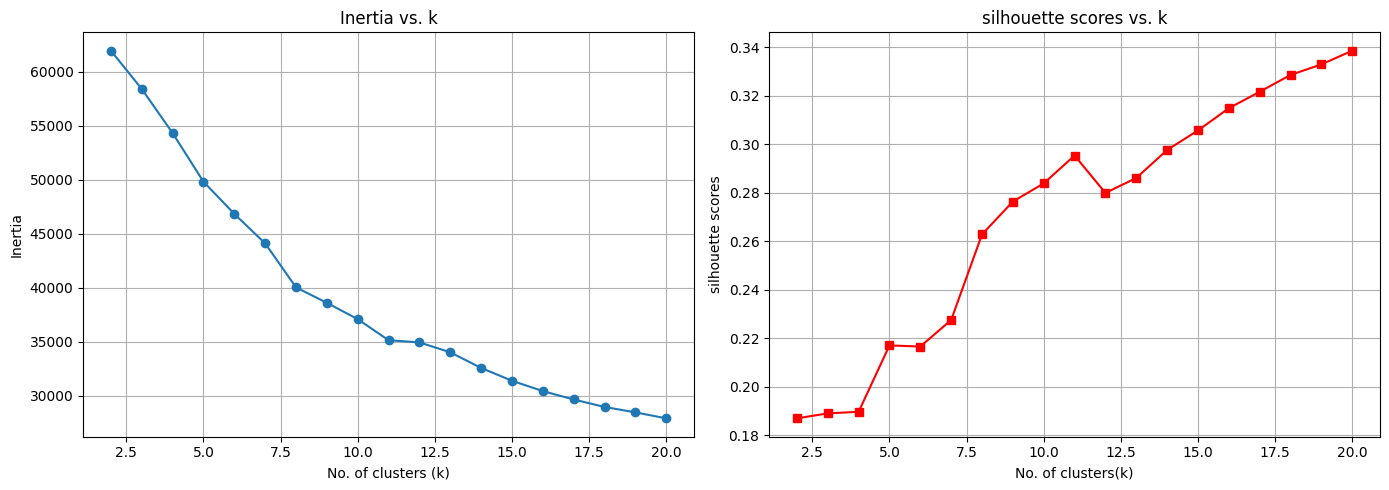

In [12]:
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)
for k in k_values:
  kmeans_model =  KMeans(n_clusters=k, random_state=42)
  kmeans_model.fit(final_features)
  inertia_values.append(kmeans_model.inertia_)
  silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Inertia vs. k')
axs[0].set_xlabel('No. of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker = 's', color='red')
axs[1].set_title('silhouette scores vs. k')
axs[1].set_xlabel('No. of clusters(k)')
axs[1].set_ylabel('silhouette scores')
axs[1].grid(True)
plt.tight_layout()
plt.show()

In [15]:
for i in range(len(inertia_values)):
  print(f"Inertia for k={k_values[i]}: {inertia_values[i]}")

Inertia for k=2: 61942.860090163515
Inertia for k=3: 58401.301498516754
Inertia for k=4: 54317.545340788216
Inertia for k=5: 49817.804706948344
Inertia for k=6: 46838.46504687354
Inertia for k=7: 44105.42240920464
Inertia for k=8: 40033.16748164262
Inertia for k=9: 38605.314110716405
Inertia for k=10: 37093.935487618815
Inertia for k=11: 35146.65175470259
Inertia for k=12: 34943.24012626113
Inertia for k=13: 34028.02922994027
Inertia for k=14: 32578.69871586075
Inertia for k=15: 31391.495735278146
Inertia for k=16: 30436.524539510083
Inertia for k=17: 29658.45265232862
Inertia for k=18: 28967.924253196743
Inertia for k=19: 28467.06255303977
Inertia for k=20: 27913.85164583662


<ipython-input-16-57b1038556e1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


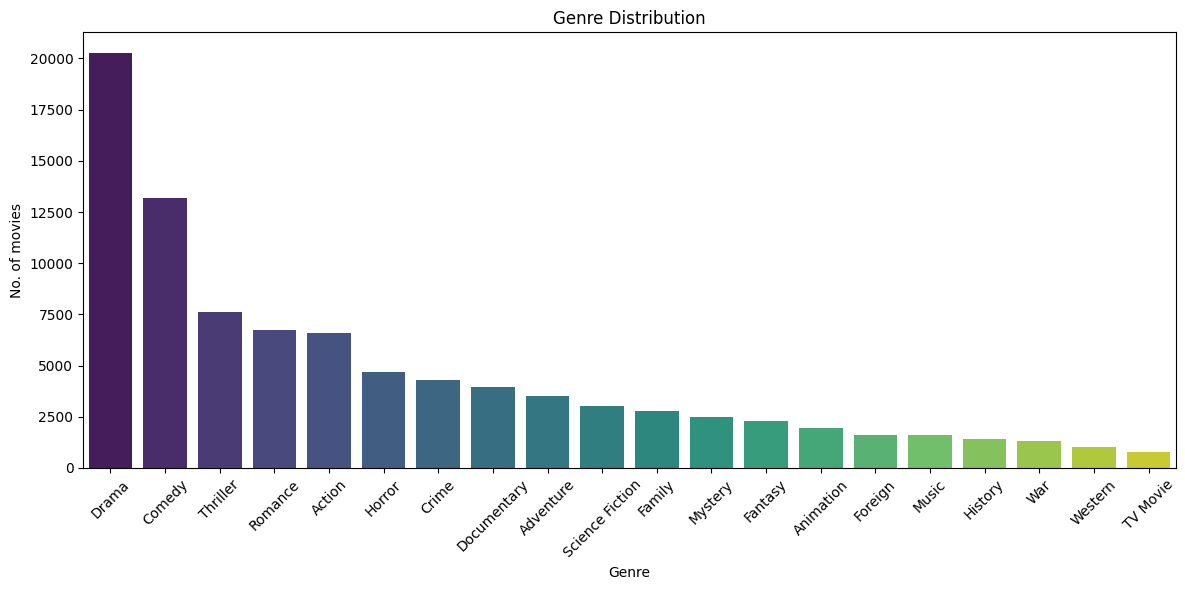

In [16]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('No. of movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

<ipython-input-17-f0c53a7769b5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies['cluster'], palette='coolwarm')


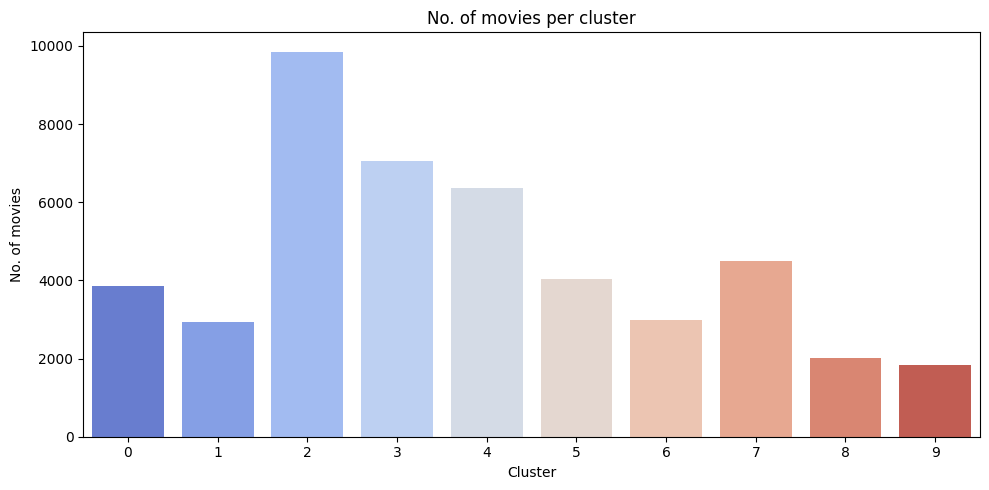

In [17]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('No. of movies per cluster')
plt.xlabel('Cluster')
plt.ylabel('No. of movies')
plt.tight_layout()
plt.show()

In [ ]:
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.

    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.

    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['title'].str.lower() == movie_title.lower()]

    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."

    # Get the cluster of the target movie
    cluster_id = target['cluster'].values[0]

    # Get all movies from the same cluster
    similar_movies = movies[(movies['cluster'] == cluster_id) &
                            (movies['title'].str.lower() != movie_title.lower())]

    # Return top N based on vote_average and popularity
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)


# Example usage:

print(" Recommended movies similar to 'Toy Story':")
print(recommend_movies("Heat", n=5))

 Recommended movies similar to 'Toy Story':
                                     title  vote_average popularity
24951                 Deliver Us from Evil          10.0   0.317373
39707                     American Hostage          10.0    0.11167
22346                       هیچ کجا هیچ کس          10.0   0.070407
25355                 The Great Kidnapping          10.0   0.049823
41698  Paradies 505. Ein Niederbayernkrimi          10.0   0.048331


In [18]:
from sklearn.metrics.pairwise import euclidean_distances
def recommend_movies(movie_title, n=5):
  target = movies[movies['title'].str.lower() == movie_title.lower()]
  if target.empty:
    return f" Movie titled '{movie_title}' not found in the dataset."
  target_idx = target.index[0]
  cluster_id = target['cluster'].values[0]
  target_vector = final_features.iloc[target_idx].values.reshape(1, -1)
  cluster_indices = movies[(movies['cluster'] == cluster_id) & (movies.index != target_idx)].index
  if cluster_indices.empty:
    return "No similar movies found in the same cluster."
  cluster_vectors = final_features.iloc[cluster_indices]
  distances = euclidean_distances(target_vector, cluster_vectors)[0]
  sorted_indices = cluster_indices[np.argsort(distances)]
  recommendations = movies.loc[sorted_indices[:n], ['title', 'vote_average', 'popularity']]
  return recommendations
print(" Recommended movies similar to 'Toy Story':")
print(recommend_movies("Toy Story", n=5))

 Recommended movies similar to 'Toy Story':
                    title  vote_average popularity
15348         Toy Story 3           7.6   16.96647
4756       Monsters, Inc.           7.5  26.419962
1110   The Wrong Trousers           7.6   7.771233
727         A Close Shave           7.5   6.796858
2997          Toy Story 2           7.3  17.547693
